In [1]:
import sys

if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')

    # Replace with correct location
    %cd /content/drive/MyDrive/Colab Notebooks/CodeNet-Sentinel/Decoder

    !pip install datasets==2.15.0 transformers lightning wandb

In [2]:
import os

# To make our imports work because python relative imports suck
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)

In [3]:
import re
import torch

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from ast import literal_eval
from datasets import load_dataset
from tqdm import tqdm

# Local Modules
from Architecture import Tokenizer, VOCAB_SIZE
from Architecture.ModelConfig import ModelConfig
from Architecture.SentinelTransformer import SentinelDataset

/Users/faustogerman/miniforge3/envs/CodeNetSentinel/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
CONFIG = ModelConfig()

torch.manual_seed(CONFIG.random_seed)
torch.__version__

'2.1.2'

In [5]:
all_data = pd.read_feather("../Data/extracted/en_data.ftr")
all_data = all_data[["problem_id", "language", "problem_description", "solution", "status"]]

all_data = all_data[all_data["status"].isin([
    "Accepted",
    "Wrong Answer",
    "Runtime Error",
    "Compile Error",
    "Time Limit Exceeded"
])]

all_data = all_data[all_data["language"].isin([
    "C++",
    "Python",
    "Java",
    "C",
    "C#",
    "Ruby",
    "Rust"
])]

In [6]:
all_data = all_data.groupby(["problem_id", "status"]).apply(
    lambda df: df.sample(min(len(df), 20))
)

all_data.drop(columns=["problem_id", "status"], inplace=True)
all_data.reset_index(inplace=True)

all_data

,problem_id,status,level_2,language,problem_description,solution
0,p00000,Accepted,2074,C++,QQ \n\nWrite a program which prints multiplica...,#include <iostream>\n\nint main()\n{\n int ...
1,p00000,Accepted,2803,C++,QQ \n\nWrite a program which prints multiplica...,#include<iostream>\n\nusing namespace std;\n\n...
2,p00000,Accepted,801,C,QQ \n\nWrite a program which prints multiplica...,#include <stdio.h>\n\nint main(){\n\tint a;\n\...
3,p00000,Accepted,787,C++,QQ \n\nWrite a program which prints multiplica...,#include <iostream>\n#include <iomanip>\n#incl...
4,p00000,Accepted,886,C++,QQ \n\nWrite a program which prints multiplica...,#include <cstdio>\n\nint main()\n{\n\tfor( int...
...,...,...,...,...,...,...
184298,p04052,Wrong Answer,410,C++,Score : 2000 points \n\nProblem Statement You ...,#include <cstdio>\n#include <cstring>\n#includ...
184299,p04052,Wrong Answer,333,Java,Score : 2000 points \n\nProblem Statement You ...,import java.io.ByteArrayInputStream;\nimport j...
184300,p04052,Wrong Answer,370,C++,Score : 2000 points \n\nProblem Statement You ...,#include<iostream>\n#include<vector>\n#include...
184301,p04052,Wrong Answer,348,C++,Score : 2000 points \n\nProblem Statement You ...,// wtf ... forgot to participate >_<\n#include...


<Axes: xlabel='language'>

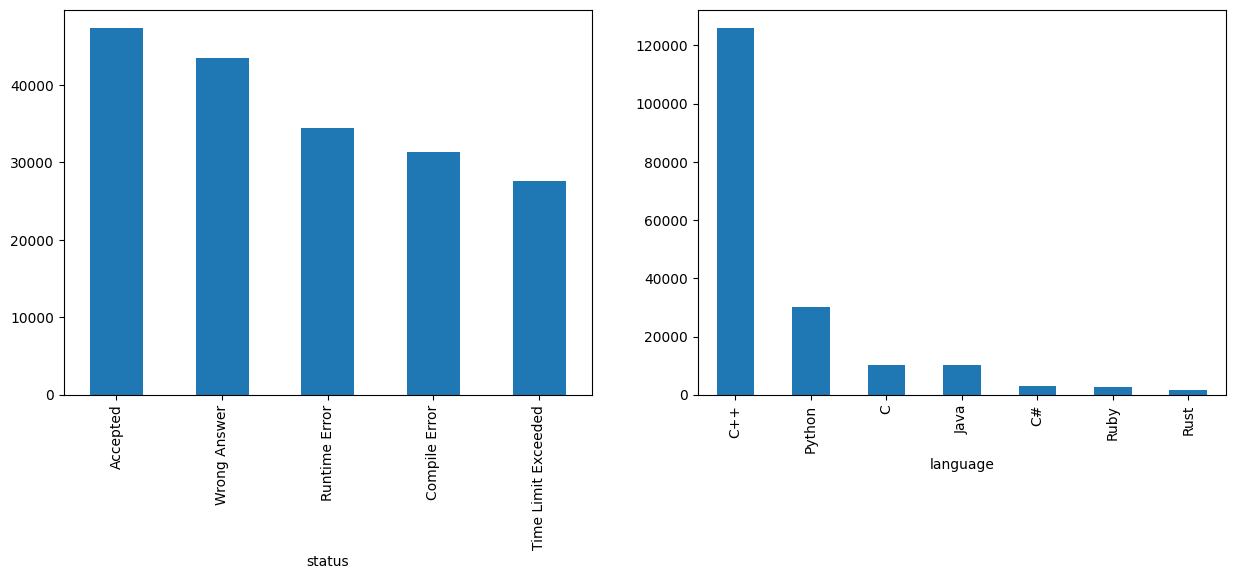

In [7]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

all_data["status"].value_counts().plot.bar(ax=axes[0])
all_data["language"].value_counts().plot.bar(ax=axes[1])

In [8]:
def tokenize_data(dataset, status_encoder):
    tokenized_triplets = {
        "question": [],
        "question_pad_mask": [],
        "answer": [],
        "answer_pad_mask": [],
        "status": [],
    }

    for qid in tqdm(dataset["problem_id"].unique()):
        current_dataset = dataset[dataset["problem_id"] == qid]

        # Tokenize the question
        tokenized_question = Tokenizer.encode(
            current_dataset["problem_description"].iloc[0],
            max_length=30_000,
            truncation=True,
            return_tensors="pt",
        )[0]

        # If the question is greater than the CONFIG.max_seq_len, then skip this subset
        # altogether because we do not want to confuse the model with half-questions.
        question_len = len(tokenized_question)
        if question_len > CONFIG.max_seq_len:
            continue

        padded_question = torch.full((CONFIG.max_seq_len,), Tokenizer.pad_token_id, dtype=torch.int64)
        padded_question[:question_len] = tokenized_question
        question_pad_mask = padded_question == Tokenizer.pad_token_id

        for solution_text, status in current_dataset[["solution", "status"]].values:
            # Tokenize the answer
            tokenized_answer = Tokenizer.encode(
                solution_text,
                max_length=30_000,
                truncation=True,
                return_tensors="pt",
            )[0]

            # If the answer is greater than the CONFIG.max_seq_len, then skip this row
            # altogether because we do not want to confuse the model with half-answers.
            answer_len = len(tokenized_answer)
            if answer_len > CONFIG.max_seq_len:
                continue

            padded_answer = torch.full((CONFIG.max_seq_len,), Tokenizer.pad_token_id, dtype=torch.int64)
            padded_answer[:answer_len] = tokenized_answer
            answer_pad_mask = padded_answer == Tokenizer.pad_token_id
                    
            # Add the question
            tokenized_triplets["question"].append(padded_question)
            tokenized_triplets["question_pad_mask"].append(question_pad_mask)

            # Add the answer
            tokenized_triplets["answer"].append(padded_answer)
            tokenized_triplets["answer_pad_mask"].append(answer_pad_mask)

            # Add the status
            tokenized_triplets["status"].append(status_encoder(status))
    
    return tokenized_triplets

In [9]:
status_values = list(all_data["status"].unique())
status_values

['Accepted',
 'Compile Error',
 'Runtime Error',
 'Time Limit Exceeded',
 'Wrong Answer']

In [10]:
tokenized_data = tokenize_data(all_data, lambda x: status_values.index(x))

100%|██████████| 2654/2654 [03:37<00:00, 12.21it/s]


In [11]:
full_dataset = SentinelDataset(tokenized_data, status_values)

In [22]:
print(Tokenizer.decode(full_dataset[1]["question"]))

QQ 

Write a program which prints multiplication tables in the following format:

```
1x1=1
1x2=2
.
.
9x8=72
9x9=81
```

Input 

No input.

Output 

```
1x1=1
1x2=2
.
.
9x8=72
9x9=81
```

Template for C 

```
#include&lt;stdio.h&gt;

int main(){

return 0;
}
```

Template for C++ 

```
#include&lt;iostream&gt;
using namespace std;

int main(){

return 0;
}
```

Template for Java 

```
class Main{

public static void main(String[] a){

}
}
```[PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD

In [23]:
print(Tokenizer.decode(full_dataset[1]["answer"]))

#include<iostream>

using namespace std;

int main(){
	int i,j;
	
	for(i=1;i<10;i++){
		for(j=1;j<10;j++){
			cout << i << "x" << j << "=" << i*j << '\n';
		}
	}
	return 0;
}[PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][

In [24]:
print(
    full_dataset[1]["status"],
    full_dataset.status_values[full_dataset[1]["status"]]
)

tensor(0) Accepted


In [17]:
full_dataset.save_to("./data/sentinel_data.pt")